# Proyecto Trading



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import coint

# Cargamos los datos, las filas son las empresas asi que trasponemos los datos
df = pd.read_csv("fundamentals_dji.csv", index_col=0).T

In [ ]:
# Paso 1: Preprocesamiento
df = df.dropna()                                                # Eliminar valores nulos
df.drop(['ticker', 'MostRecentQuarter'], axis=1, inplace=True)  # Quitamos columnas no numéricas
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)  # Normalización

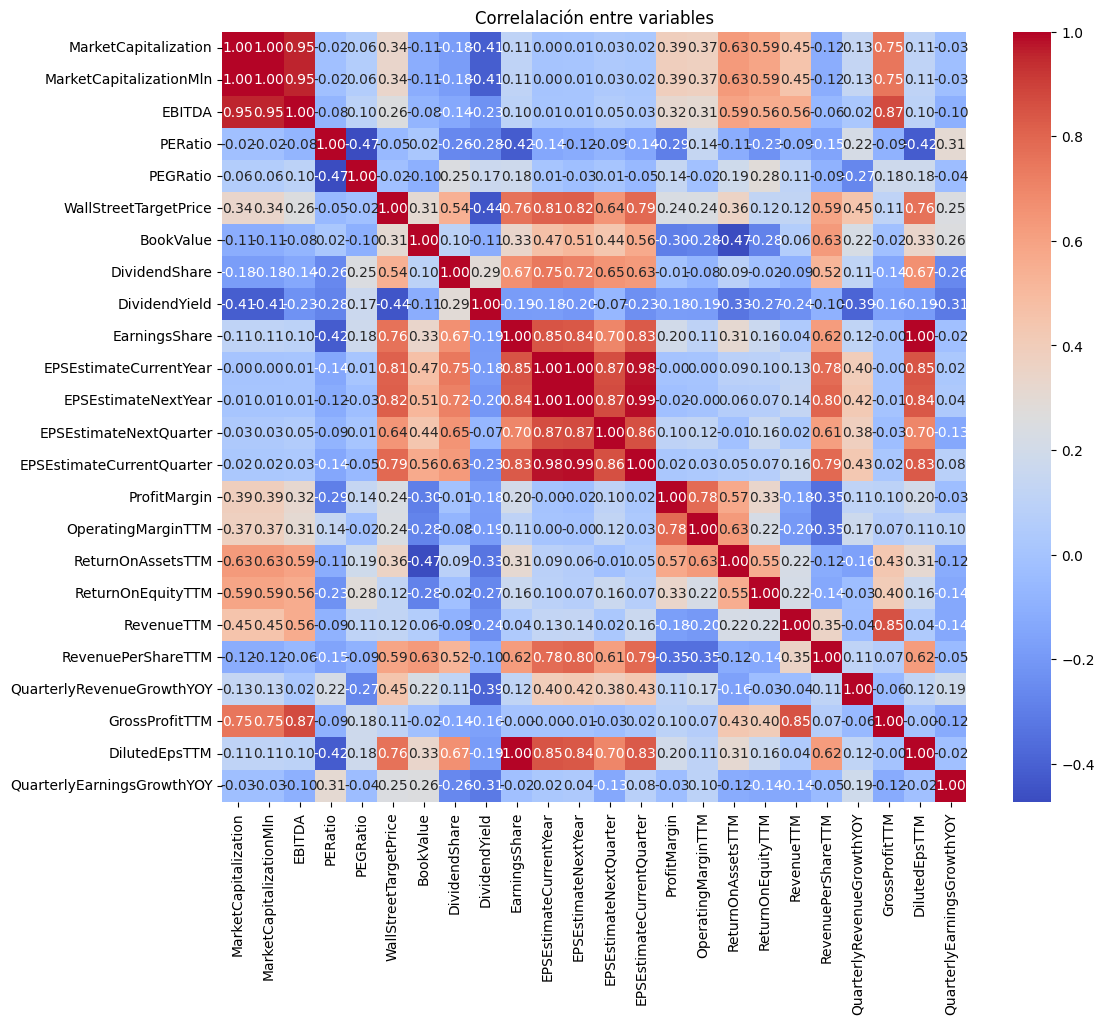

In [ ]:
# Visualizar correlaciones entre variables
plt.figure(figsize=(12, 10))
sns.heatmap(df_scaled.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlalación entre variables')
plt.show()

### Ejercicio 1. Aplicar un método de clustering a los componentes del Dow Jones usando algunas de las variables fundamentales
Primero, se ha usado StandardScaler para escalar los datos. Esto es necesario para tener todos los datos en la misma escala, porque por ejemplo, la capitalización de mercado puede estar en miles de millones, mientras que el PEG Ratio suele ser un número pequeño.

A partir de la matriz de correlación se puede observar que hay grupos de variables altamente con alta correlación entre sí (MarketCapitalization, MarketCapitalizationMln, EBITDA, GrossProfitTTM) (ErningsShare, EPSEstimateCurrentYear, EPSEstimateNextYear, EPSEstimateNextQuarter, EPSEstimateCurrentQuarter, DilutedEpsTTM, RevenuePerShareTTM) (ProfitMargin, OperatingMarginTTM, RevenueOnAssetsTTM)

A continuacion, ara evitar redundancias y mejorar la calidad del clustering se escogerá una variable por cara grupo altamente correlacionado y se utilizará el método de clustering aglomerativo con el criterio de enlace Ward, que minimiza la varianza dentro de los clusters.



In [ ]:
# Paso 2: Eliminar variables redundantes (colinealidad)
correlation_matrix = df_scaled.corr().abs()

# Seleccionar una variable por cada par altamente correlacionado (> 0.9)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]

df_filtered = df_scaled.drop(columns=correlated_features)  # Eliminar variables redundantes
print(f"Variables a eliminar: {correlated_features}")

Variables a eliminar: ['MarketCapitalizationMln', 'EBITDA', 'EPSEstimateCurrentYear', 'EPSEstimateNextYear', 'EPSEstimateNextQuarter', 'EPSEstimateCurrentQuarter', 'RevenuePerShareTTM', 'GrossProfitTTM', 'DilutedEpsTTM']


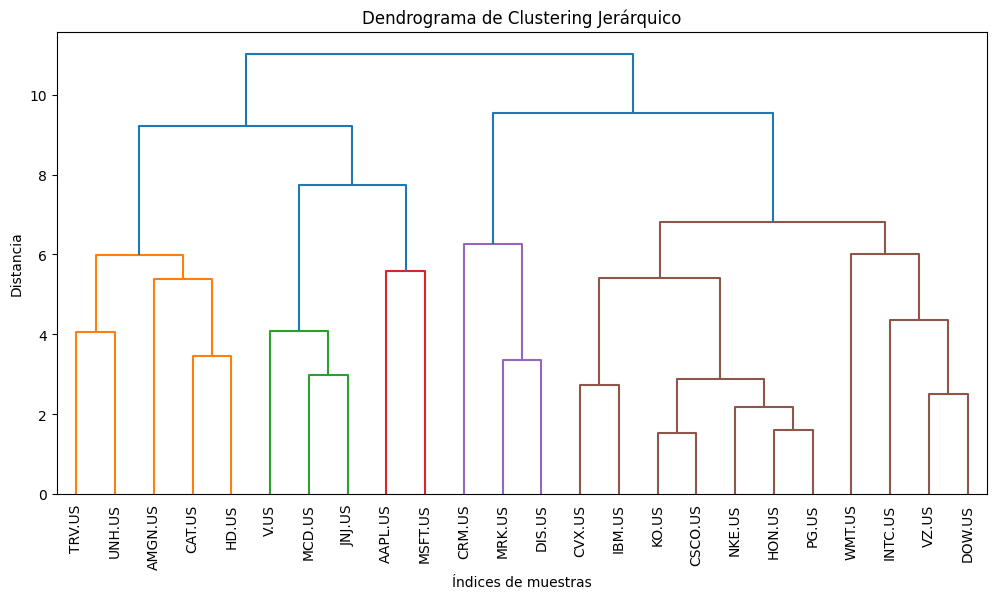

In [ ]:
# Calculamos la matriz de distancias
dist_matrix = pdist(df_filtered, metric='euclidean')

# Aplicamos clustering jerárquico
linkage_matrix = sch.linkage(dist_matrix, method='ward')

# Visualizamos el Dendrograma
plt.figure(figsize=(12, 6))
sch.dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90)
plt.title("Dendrograma de Clustering Jerárquico")
plt.xlabel("Índices de muestras")
plt.ylabel("Distancia")
plt.show()

### 2. Elegid de cada grupo dos acciones para aplicar la estrategia de pairs trading


Tras el análisis de clusters realizado, se han identificado grupos de empresas que comparten características fundamentales similares. Para la implementación de la estrategia de pairs trading, se han seleccionado los siguientes pares de cada cluster, fundamentando la elección en sus características comunes:

*   **UnitedHealth y Amgen**: ambas empresas están fuertemente vinculadas al sector salud.
*   **Visa y Johnson & Johnson**: a pesar de operar en sectores diferentes, ambas compañías comparten características de empresas blue-chip, con alta capitalización y estabilidad en el mercado.
*   **Apple y Microsoft**: ambas empresas destacan como líderes  del sector tecnológico, especializadas en software, hardware y servicios digitales.
*    **Merck y Disney**: aunque operan en industrias diferentes, ambas son empresas con una larga trayectoria y diversificación en sus respectivos sectores.
*   **IBM e Intel**: ambas empresas son pioneras en el sector tecnológico, especialmente en el desarrollo de hardware y soluciones empresariales

### 3. Elegid un intervalo de entre 3 y 5 años de todos los disponibles para el estudio

Para determinar el intervalo más adecuado para cada par de acciones, se ha implementado un análisis que evalúa la cointegración entre cada par de acciones en todos los intervalos posibles dentro del rango temporal disponible. Esta función emplea el test de cointegración de Engle-Granger para cada ventana temporal.

El procedimiento es el siguiente:

1. Se analizan ventanas temporales de 3, 4 y 5 años
2.   Para cada ventana, se desplaza año a año sobre todo el período disponible
3. Se calcula el p-valor del test de cointegración para cada intervalo
4. Se selecciona el intervalo que presenta el menor p-valor, ya que esto indica la evidencia más fuerte de cointegración entre el par de acciones





### 4. Comparad las PnL obtenidas por cada par, intentad explicar las diferencias en estos resultados mirando los grupos que se han creado

El proceso se estructura de la siguiente manera:


1.   Cálculo de ratios y señales:

  *   Se calcula el ratio de precios entre cada par de acciones
  *   Se determina el z-score para identificar las desviaciones de la media
  *   Se establecen las señales de trading basadas en umbrales del z-score
  *   Se implementan las reglas de entrada y salida de posiciones


2.   Evaluación de rendimiento:
  *   Se calculará el PnL para cada operación
  *   Se generarán visualizaciones de la evolución del PnL acumulado
  *   Se analizarán métricas de rendimiento como el ratio de Sharpe y la máxima drawdown



# UnitedHealth y Amgen

In [ ]:
# Pareja nº1: UnitedHealth y Amgen
df_united = pd.read_csv("UNH_US_datos.csv", parse_dates=["date"], index_col="date").drop(columns=["Unnamed: 0"], errors="ignore")
df_amgen = pd.read_csv("AMGN_US_datos.csv", parse_dates=["date"], index_col="date").drop(columns=["Unnamed: 0"], errors="ignore")

In [ ]:
def check_cointegration_in_periods(stock1, stock2, start_year, end_year, window_range=(3, 5)):
    common_dates = stock1.index.intersection(stock2.index)
    stock1 = stock1.loc[common_dates]
    stock2 = stock2.loc[common_dates]
    results = []

    for window in range(window_range[0], window_range[1] + 1):  # Iterar sobre ventanas de 3, 4 y 5 años
        for year in range(start_year, end_year - window + 1, 1):
            start_date = f"{year}-01-01"
            end_date = f"{year + window}-01-01"

            # Filtrar datos dentro del intervalo
            stock1_subset = stock1.loc[start_date:end_date].dropna()
            stock2_subset = stock2.loc[start_date:end_date].dropna()

            # Asegurar que hay suficientes datos
            if len(stock1_subset) > 10 and len(stock2_subset) > 10:  # Se necesita un mínimo de datos para la cointegración
                score, p_value, _ = coint(stock1_subset, stock2_subset)
                results.append((start_date, end_date, window, p_value))
            else:
                results.append((start_date, end_date, window, None))  # Indicar que no había suficientes datos

    return results

In [ ]:
# Para seleccionar el intervalo de tiempo evaluamos la cointegración en intervalos de 3 a 5 años desde 2004 hasta 2023
cointegration_results = check_cointegration_in_periods(df_united["adjusted_close"], df_amgen["adjusted_close"], 2004, 2023, window_range=(3, 5))

# Convertimos los resultados en DataFrame para análisis
df_cointegration = pd.DataFrame(cointegration_results, columns=["Start", "End", "Window", "P-value"])
df_cointegration["Start"] = pd.to_datetime(df_cointegration["Start"])
df_cointegration.set_index("Start", inplace=True)

# Mostrar resultados con p-values significativos
print(df_cointegration[df_cointegration["P-value"] < 0.05])

                   End  Window   P-value
Start                                   
2008-01-01  2011-01-01       3  0.027606
2011-01-01  2015-01-01       4  0.039303
2015-01-01  2019-01-01       4  0.009975


In [ ]:
# Definimos funciones para
def visualizar_stocks(df1, df2, df1_label, df2_label, start_date, end_date):
  plt.figure(figsize=(12, 6))
  plt.plot(df1.index, df1["adjusted_close"], label=f"{df1_label}")
  plt.plot(df2.index, df2["adjusted_close"], label=f"{df2_label}")
  plt.title(f"Precios ajustados de {df1_label} y {df2_label} ({start_date}-{end_date})")
  plt.xlabel("Fecha")
  plt.ylabel("Precio ajustado")
  plt.legend()
  plt.grid(True)
  plt.show()

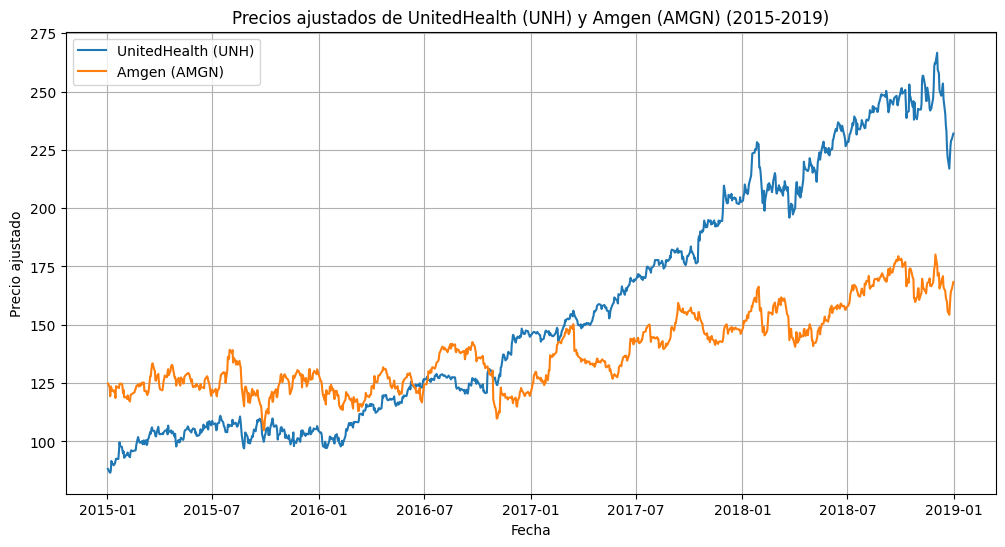

In [ ]:
# Seleccionamos el intervalo de tiempo, a partir de los resultado otenidos al evaluar la cointegración
df_united = df_united.loc['2015-01-01':'2019-01-01']
df_amgen = df_amgen.loc['2015-01-01':'2019-01-01']

visualizar_stocks(df_united, df_amgen, "UnitedHealth (UNH)", "Amgen (AMGN)", 2015, 2019)

In [ ]:
def calucular_ratio(df1, df2, df1_label, df2_label):
  ratio = df1["adjusted_close"] / df2["adjusted_close"]
  def zscore(series):
      return (series - series.mean()) / np.std(series)

  # Calcular el Z-Score del ratio
  z_score = zscore(ratio)

  # Visualizar el ratio
  plt.figure(figsize=(12, 5))
  plt.plot(ratio, label=f"Ratio {df1_label}/{df2_label}")
  plt.axhline(ratio.mean(), color='black', linestyle="--", label="Media")
  plt.axhline(ratio.mean() + 1.0 * ratio.std(), color='red', linestyle="--", label="Media + 1STD")
  plt.axhline(ratio.mean() - 1.0 * ratio.std(), color='green', linestyle="--", label="Media - 1STD")
  plt.legend()
  plt.title("Ratio de precios y niveles de trading")
  plt.show()
  return ratio, z_score

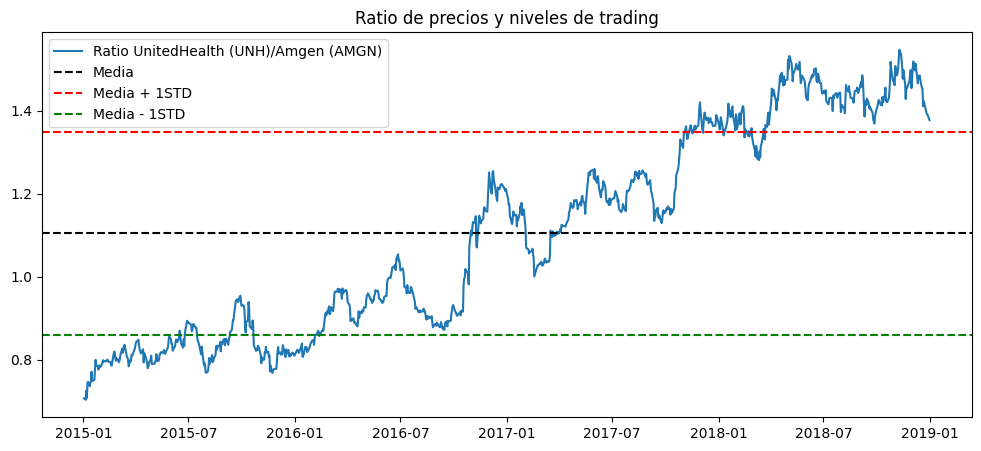

In [ ]:
ratio, z_score = calucular_ratio(df_united, df_amgen, "UnitedHealth (UNH)", "Amgen (AMGN)")

In [ ]:
def calcular_señales(ratio, z_score, df1_label, df2_label):
  # Generar señales de trading
  buy_signal = z_score < -1  # Comprar el spread (stock1 barato, stock2 caro)
  sell_signal = z_score > 1   # Vender el spread (stock1 caro, stock2 barato)

  # Visualizar señales en el gráfico del ratio
  plt.figure(figsize=(12, 5))
  plt.plot(ratio, label="Ratio AAPL/MSFT")
  plt.plot(ratio[buy_signal], marker="^", markersize=8, linestyle="None", color="g", label="Compra")
  plt.plot(ratio[sell_signal], marker="v", markersize=8, linestyle="None", color="r", label="Venta")
  plt.legend()
  plt.title(f"Señales de Trading en el Ratio {df1_label}/{df2_label}")
  plt.show()
  return buy_signal, sell_signal

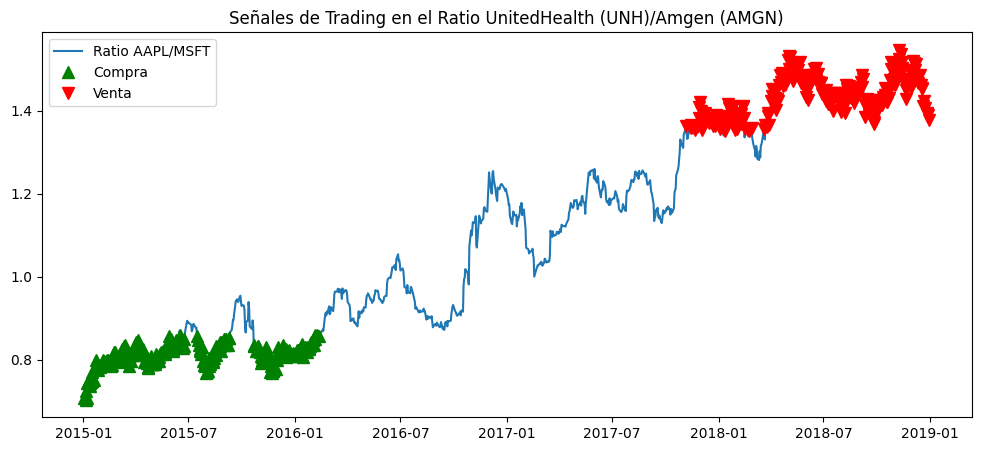

In [ ]:
buy_signal, sell_signal = calcular_señales(ratio, z_score, "UnitedHealth (UNH)", "Amgen (AMGN)")

In [ ]:
def calcular_señales_pairs(df1, df2, ratio, z_score, df1_label, df2_label):
    buy_signal1 = df1["adjusted_close"][buy_signal]  # Stock1 se compra
    sell_signal1 = df1["adjusted_close"][sell_signal]  # Stock1 se vende

    buy_signal2 = df2["adjusted_close"][sell_signal]  # Stock2 se compra
    sell_signal2 = df2["adjusted_close"][buy_signal]  # Stock2 se vende

    # Visualizar señales en el gráfico de precios de ambas acciones
    plt.figure(figsize=(12, 5))
    plt.plot(df1.index, df1["adjusted_close"], label=f"{df1_label}")
    plt.plot(df2.index, df2["adjusted_close"], label=f"{df2_label}")

    # Señales de compra
    plt.scatter(buy_signal1.index, buy_signal1, marker="^", color="g", label="Buy ")
    plt.scatter(buy_signal2.index, buy_signal2, marker="^", color="g")

    # Señales de venta
    plt.scatter(sell_signal1.index, sell_signal1, marker="v", color="r", label="Sell")
    plt.scatter(sell_signal2.index, sell_signal2, marker="v", color="r")

    plt.legend()
    plt.title(f"Señales de Trading en Pairs Trading {df1_label} / {df2_label}")
    plt.show()
    return buy_signal1, sell_signal1

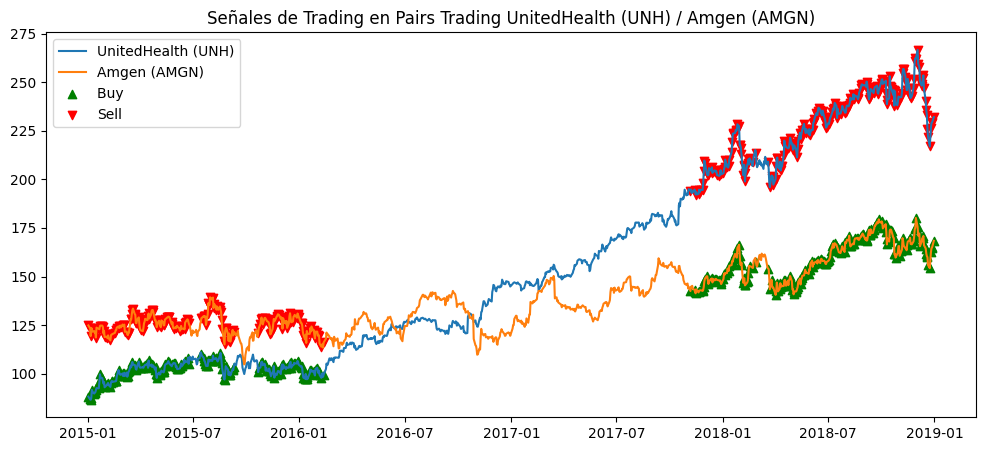

In [ ]:
buy_signal1, sell_signal1 = calcular_señales_pairs(df_united, df_amgen, ratio, z_score, "UnitedHealth (UNH)", "Amgen (AMGN)")

In [ ]:
def ejecutar_trading_pairs(df1, df2, df1_label, df2_label, buy_signal, sell_signal):
    pair_trading_strategy = pd.DataFrame(index=df1.index)
    pair_trading_strategy['Stock1_price'] = df1["adjusted_close"]
    pair_trading_strategy['Stock2_price'] = df2["adjusted_close"]
    pair_trading_strategy['Stock1_buy'] = np.nan
    pair_trading_strategy['Stock1_sell'] = np.nan
    pair_trading_strategy['Stock2_buy'] = np.nan
    pair_trading_strategy['Stock2_sell'] = np.nan

    # Inicializar variables de posición
    position = 0  # 1 si estamos en largo, -1 si estamos en corto, 0 si no hay posición
    stock1_shares = 1_000_000  # Capital inicial en acciones de Stock1

    for i in range(len(df1)):
        stock1_price = df1["adjusted_close"].iloc[i]
        stock2_price = df2["adjusted_close"].iloc[i]

        # Si no tenemos una posición abierta y hay señal de compra
        if position == 0 and buy_signal.iloc[i]:
            pair_trading_strategy.at[df1.index[i], 'Stock1_buy'] = stock1_price
            pair_trading_strategy.at[df2.index[i], 'Stock2_sell'] = stock2_price
            position = 1

        # Si no tenemos una posición abierta y hay señal de venta
        elif position == 0 and sell_signal.iloc[i]:
            pair_trading_strategy.at[df1.index[i], 'Stock1_sell'] = stock1_price
            pair_trading_strategy.at[df2.index[i], 'Stock2_buy'] = stock2_price
            position = -1

        # Si estamos en corto y se da la condición de salida (sin señal de venta o último día)
        elif position == -1 and (not sell_signal.iloc[i] or i == len(df1) - 1):
            pair_trading_strategy.at[df1.index[i], 'Stock1_buy'] = stock1_price
            pair_trading_strategy.at[df2.index[i], 'Stock2_sell'] = stock2_price
            position = 0

        # Si estamos en largo y se da la condición de salida (sin señal de compra o último día)
        elif position == 1 and (not buy_signal.iloc[i] or i == len(df1) - 1):
            pair_trading_strategy.at[df1.index[i], 'Stock1_sell'] = stock1_price
            pair_trading_strategy.at[df2.index[i], 'Stock2_buy'] = stock2_price
            position = 0

    # Visualización de las señales de trading sobre los precios de Stock1
    plt.figure(figsize=(12, 5))
    plt.plot(df1["adjusted_close"], label=f"{df1_label} Price")
    plt.plot(pair_trading_strategy['Stock1_buy'], marker="^", markersize=8, linestyle="None", color="g")
    plt.plot(pair_trading_strategy['Stock1_sell'], marker="v", markersize=8, linestyle="None", color="r")
    # Visualización de las señales de trading sobre los precios de Stock2
    plt.plot(df2["adjusted_close"], color='orange', label=f"{df2_label} Price")
    plt.plot(pair_trading_strategy['Stock2_buy'], marker="^", markersize=8, linestyle="None", color="g", label="Compra")
    plt.plot(pair_trading_strategy['Stock2_sell'], marker="v", markersize=8, linestyle="None", color="r", label="Venta")

    plt.legend()
    plt.title(f"Señales de Trading en {df1_label} y {df2_label}")
    plt.show()

    pair_trading_strategy['Stock1_buy'] = pair_trading_strategy['Stock1_buy'].fillna(0)
    pair_trading_strategy['Stock1_sell'] = pair_trading_strategy['Stock1_sell'].fillna(0)
    pair_trading_strategy['Stock2_buy'] = pair_trading_strategy['Stock2_buy'].fillna(0)
    pair_trading_strategy['Stock2_sell'] = pair_trading_strategy['Stock2_sell'].fillna(0)
    return pair_trading_strategy

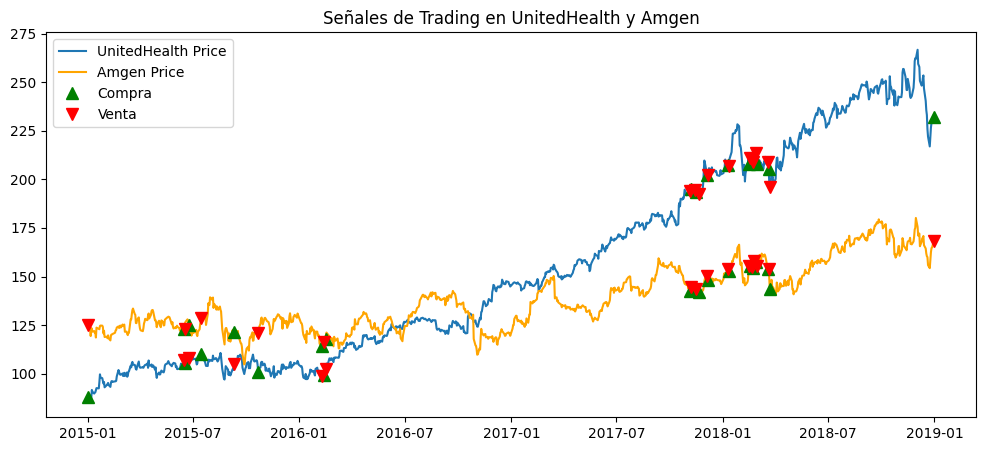

In [ ]:
pair_trading_strategy = ejecutar_trading_pairs(df_united, df_amgen, "UnitedHealth", "Amgen", buy_signal, sell_signal)

In [ ]:
def calcular_posiciones(pair_trading_strategy, df1_label, df2_label):
    # Calcular las posiciones acumuladas para Stock1 y Stock2
    # sustituimos los nan por 0
    pair_trading_strategy['Stock1_position'] = (
        pair_trading_strategy['Stock1_buy'].fillna(0) - pair_trading_strategy['Stock1_sell'].fillna(0)
    )

    pair_trading_strategy['Stock2_position'] = (
        pair_trading_strategy['Stock2_buy'].fillna(0) - pair_trading_strategy['Stock2_sell'].fillna(0)
    )

    # Calcular la posición total combinada
    pair_trading_strategy['total_position'] = (
        pair_trading_strategy['Stock1_position'] + pair_trading_strategy['Stock2_position']
    )

    # Graficar las posiciones acumuladas individuales
    plt.figure(figsize=(12, 5))
    pair_trading_strategy['Stock1_position'].cumsum().plot(label=f"{df1_label} Position")
    pair_trading_strategy['Stock2_position'].cumsum().plot(label=f"{df2_label} Position")
    pair_trading_strategy['total_position'].cumsum().plot(label="Total Position")
    plt.title(f"Posición {df1_label} y {df2_label} Total Acumulada")
    plt.legend()
    plt.show()

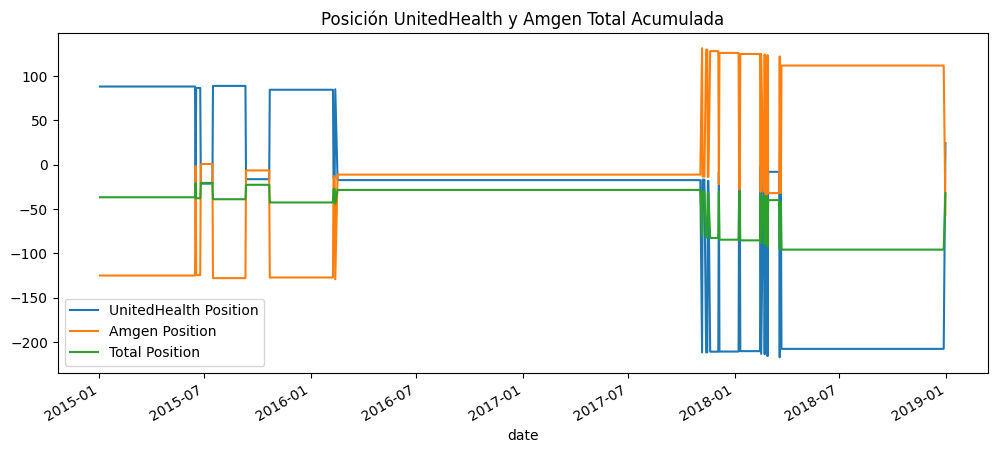

In [ ]:
calcular_posiciones(pair_trading_strategy, "UnitedHealth", "Amgen")

In [ ]:
def calcular_pnl(df1, df2, ratio, z_score, buy_signal, sell_signal, df1_label, df2_label, capital = 1000000):
    # Crear un DataFrame para almacenar la estrategia
    trading_strategy = pd.DataFrame(index=df1.index)
    trading_strategy["Stock1 Price"] = df1["adjusted_close"]
    trading_strategy["Stock2 Price"] = df2["adjusted_close"]
    trading_strategy["Ratio"] = ratio
    trading_strategy["Z-Score"] = z_score
    trading_strategy["Buy Signal"] = buy_signal.astype(int)
    trading_strategy["Sell Signal"] = sell_signal.astype(int)

    # Definir el tamaño de la posición
    position_size = capital / df1["adjusted_close"]  # Número de acciones de Stock1 a comprar
    trading_strategy["Stock1 Position"] = position_size * trading_strategy["Buy Signal"] - position_size * trading_strategy["Sell Signal"]

    # Calcular el PnL
    trading_strategy["PnL"] = trading_strategy["Stock1 Position"].shift(1) * (trading_strategy["Stock1 Price"].pct_change())

    # PnL acumulado
    trading_strategy["PnL Cumulative"] = trading_strategy["PnL"].cumsum()

    # Graficar PnL
    plt.figure(figsize=(12, 5))
    plt.plot(trading_strategy["PnL Cumulative"], label="PnL Acumulado")
    plt.axhline(0, color='black', linestyle="--")
    plt.legend()
    plt.title(f"Evolución del PnL de la Estrategia de Pairs Trading para {df1_label} y {df2_label}")
    plt.show()

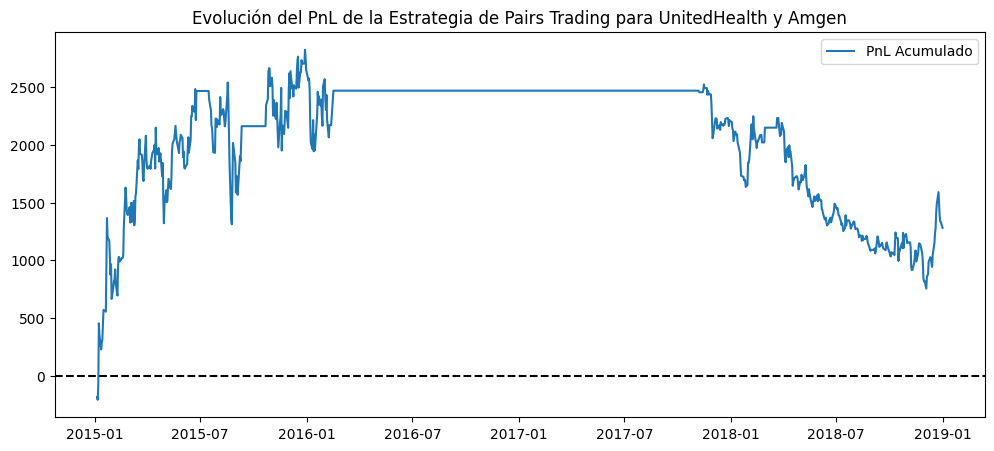

In [ ]:
calcular_pnl(df_united, df_amgen, ratio, z_score, buy_signal, sell_signal, "UnitedHealth", "Amgen")

Analizando el gráfico de PNL para UnitedHealth y Amgen, se pueden identificar tres fases:

Desde 2015 hasta 2016 se observa una fase de crecimiento, donde el PNL acumulado aumenta desde 0 hasta aproximadamente 2000-2500 puntos, mostrando una estrategia inicialmente muy efectiva.

Del 2016 al 2017 el PNL se mantiene relativamente estable alrededor de los 2500 puntos, sugiriendo un período de consolidación donde la estrategia mantuvo sin grandes variaciones.

Finalmente, del 2018 al 2019 se aprecia una caída sostenida hasta niveles cercanos a 1000 puntos, indicando que la estrategia de pairs trading perdió efectividad, posiblemente debido a cambios en la correlación entre ambos activos o en las condiciones del mercado. Por otro lado, a principios de 2019 se recupera ligeramente.

# Visa y Johnson & Johnson

In [ ]:
# Pareja nº2: Visa y Johnson & Johnson
df_visa = pd.read_csv("V_US_datos.csv", parse_dates=["date"], index_col="date").drop(columns=["Unnamed: 0"], errors="ignore")
df_jnj = pd.read_csv("JNJ_US_datos.csv", parse_dates=["date"], index_col="date").drop(columns=["Unnamed: 0"], errors="ignore")

In [ ]:
# Para seleccionar el intervalo de tiempo evaluamos la cointegración en intervalos de 3 a 5 años desde 2004 hasta 2023
cointegration_results = check_cointegration_in_periods(df_visa["adjusted_close"], df_jnj["adjusted_close"], 2008, 2023, window_range=(3, 5))

# Convertimos los resultados en DataFrame para análisis
df_cointegration = pd.DataFrame(cointegration_results, columns=["Start", "End", "Window", "P-value"])
df_cointegration["Start"] = pd.to_datetime(df_cointegration["Start"])
df_cointegration.set_index("Start", inplace=True)

# Mostrar resultados con p-values significativos
print(df_cointegration[df_cointegration["P-value"] < 0.05])

                   End  Window   P-value
Start                                   
2009-01-01  2012-01-01       3  0.042428
2019-01-01  2022-01-01       3  0.037763
2008-01-01  2012-01-01       4  0.040202
2018-01-01  2022-01-01       4  0.040440


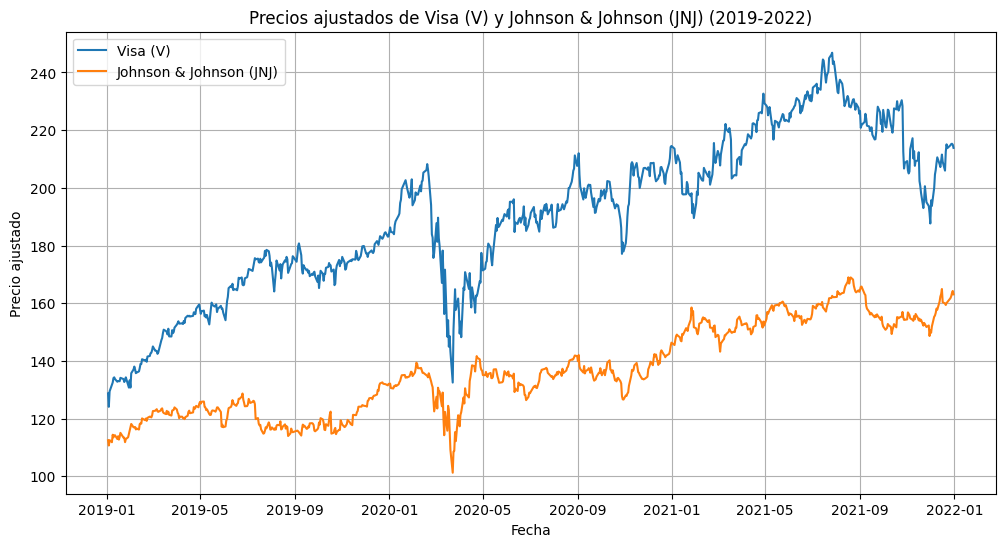

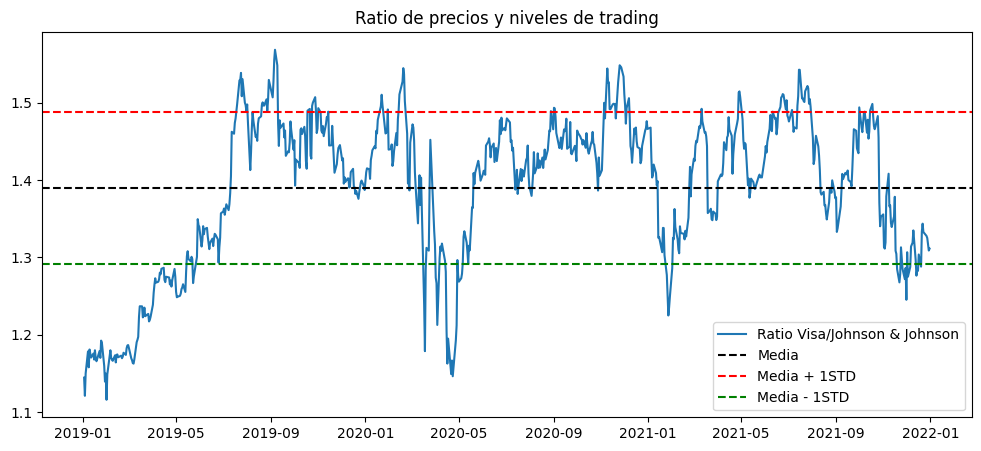

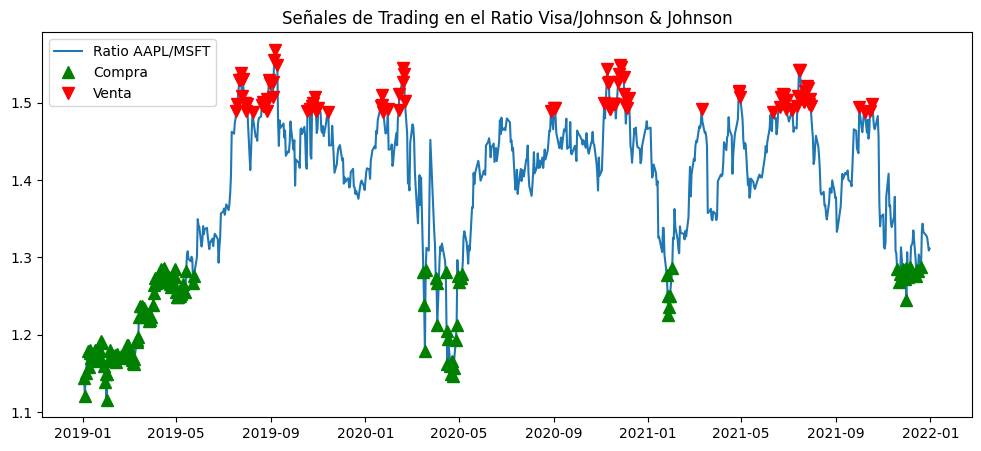

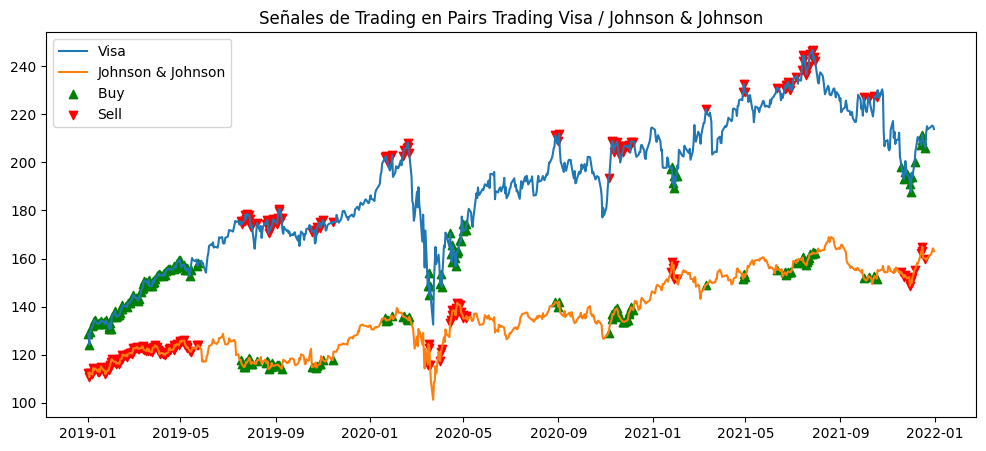

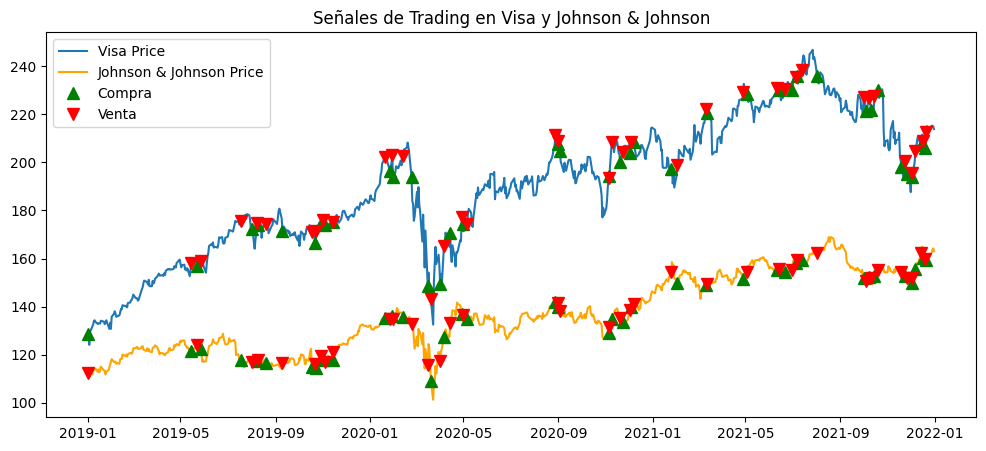

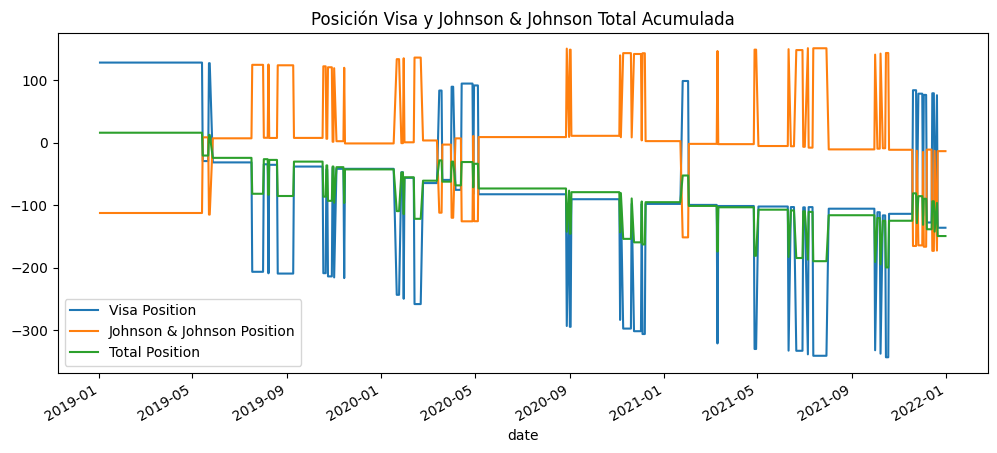

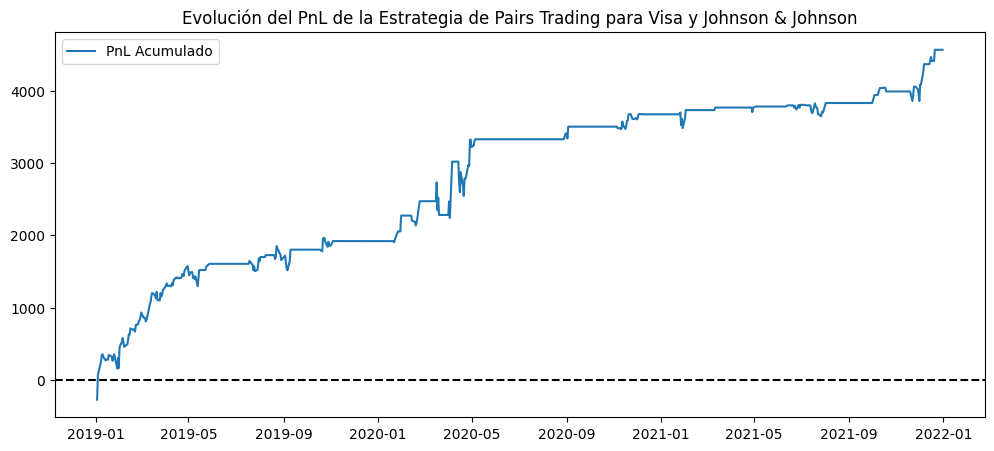

In [ ]:
# Seleccionamos el intervalo de tiempo
df_visa = df_visa.loc['2019-01-01':'2022-01-01']
df_jnj = df_jnj.loc['2019-01-01':'2022-01-01']

visualizar_stocks(df_visa, df_jnj, "Visa (V)", "Johnson & Johnson (JNJ)", 2019, 2022)
ratio, z_score = calucular_ratio(df_visa, df_jnj, "Visa", "Johnson & Johnson")
buy_signal, sell_signal = calcular_señales(ratio, z_score, "Visa", "Johnson & Johnson")
calcular_señales_pairs(df_visa, df_jnj, ratio, z_score, "Visa", "Johnson & Johnson")
pair_trading_strategy = ejecutar_trading_pairs(df_visa, df_jnj, "Visa", "Johnson & Johnson", buy_signal, sell_signal)
calcular_posiciones(pair_trading_strategy, "Visa", "Johnson & Johnson")
calcular_pnl(df_visa, df_jnj, ratio, z_score, buy_signal, sell_signal, "Visa", "Johnson & Johnson")

Analizando el gráfico de PNL para Visa y Johnson & Johnson, se pueden identificar tres fases:

Desde 2015 hasta mediados de 2019 se observa una fase de crecimiento gradual, donde el PNL acumulado aumenta de manera constante desde 0 hasta aproximadamente 2000 puntos, mostrando una estrategia consistente y efectiva.

De finales de 2019 hasta mediados de 2020 se aprecia una fase de crecimiento acelerado, con un aumento significativo hasta los 3000 puntos, posiblemente influenciado por las condiciones de mercado durante la pandemia.

Finalmente, desde mediados de 2020 hasta 2022 el PNL muestra una tendencia alcista más moderada pero sostenida, alcanzando niveles superiores a 4000 puntos.

# Apple y Microsoft

In [ ]:
# Pareja nº3: Apple y Microsoft
df_apple = pd.read_csv("AAPL_US_datos.csv", parse_dates=["date"], index_col="date").drop(columns=["Unnamed: 0"], errors="ignore")
df_microsoft = pd.read_csv("MSFT_US_datos.csv", parse_dates=["date"], index_col="date").drop(columns=["Unnamed: 0"], errors="ignore")

In [ ]:
# Para seleccionar el intervalo de tiempo evaluamos la cointegración en intervalos de 3 a 5 años desde 2004 hasta 2023
cointegration_results = check_cointegration_in_periods(df_apple["adjusted_close"], df_microsoft["adjusted_close"], 2004, 2023, window_range=(3, 5))

# Convertimos los resultados en DataFrame para análisis
df_cointegration = pd.DataFrame(cointegration_results, columns=["Start", "End", "Window", "P-value"])
df_cointegration["Start"] = pd.to_datetime(df_cointegration["Start"])
df_cointegration.set_index("Start", inplace=True)

# Mostrar resultados con p-values significativos
df_cointegration["P-value"] = df_cointegration["P-value"].astype(float)
print(df_cointegration[df_cointegration["P-value"] < 0.05])

Empty DataFrame
Columns: [End, Window, P-value]
Index: []


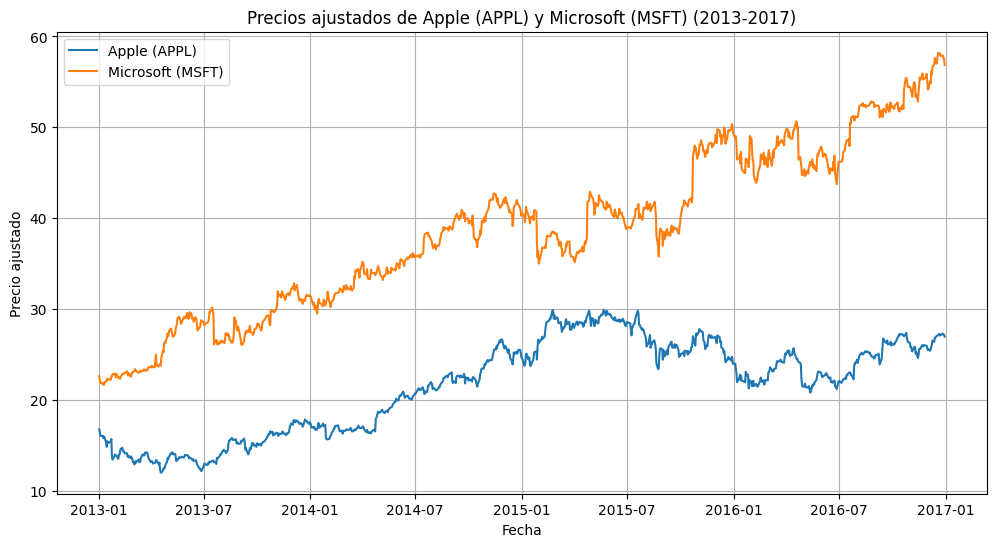

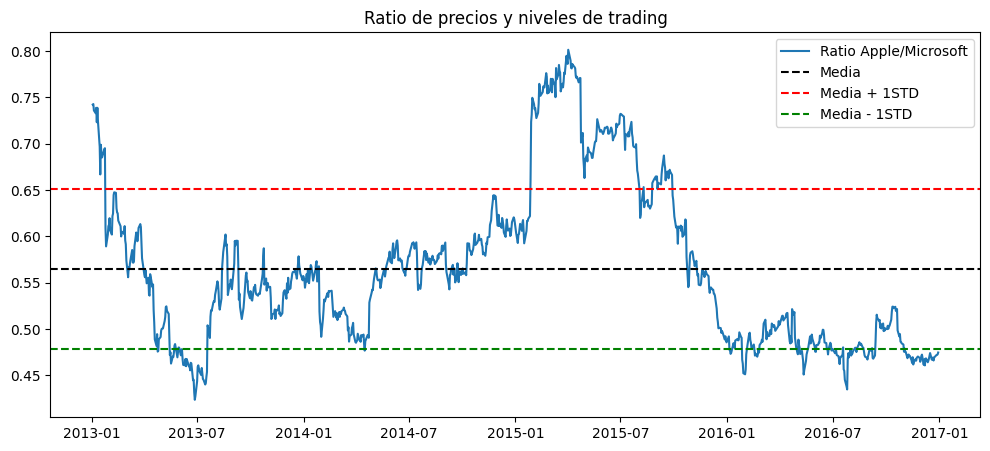

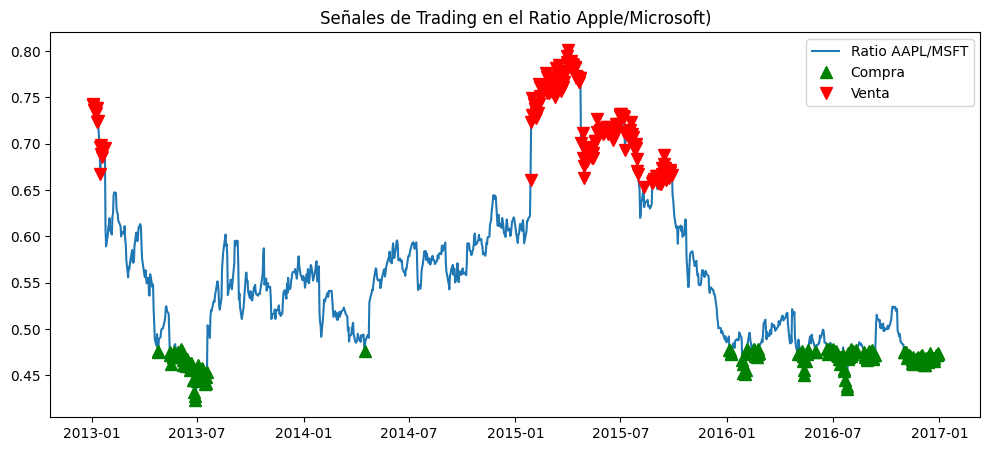

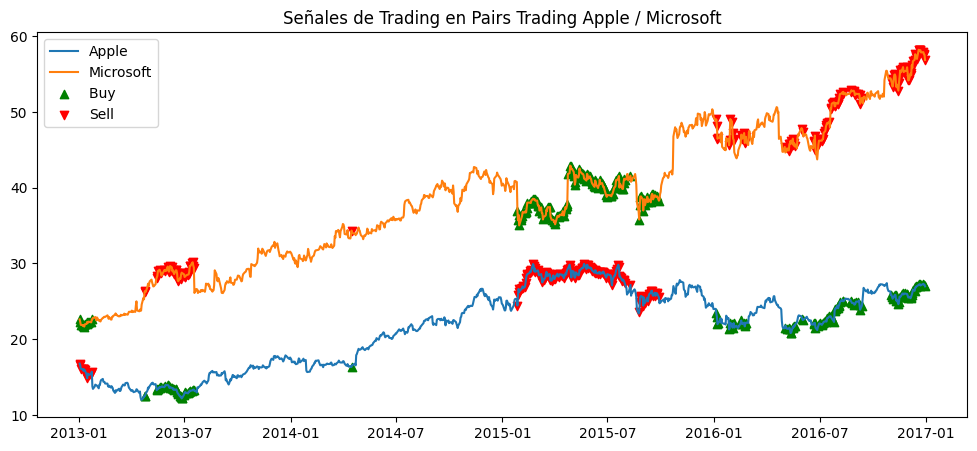

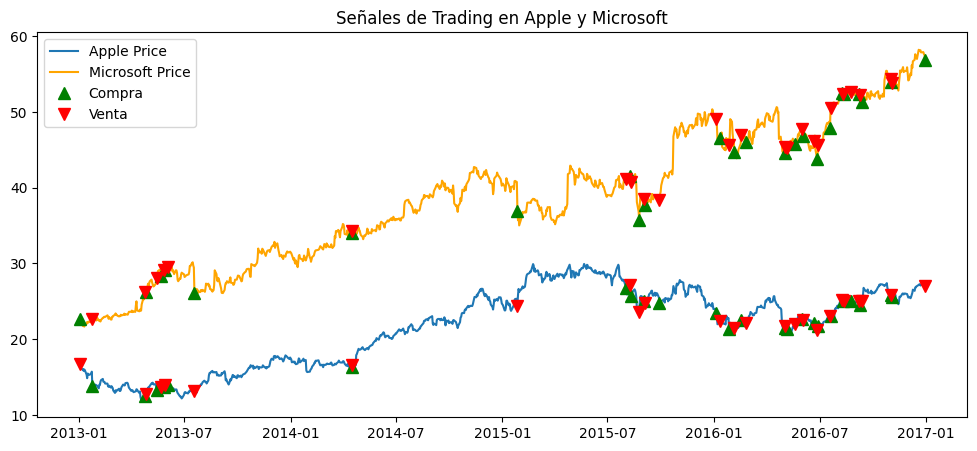

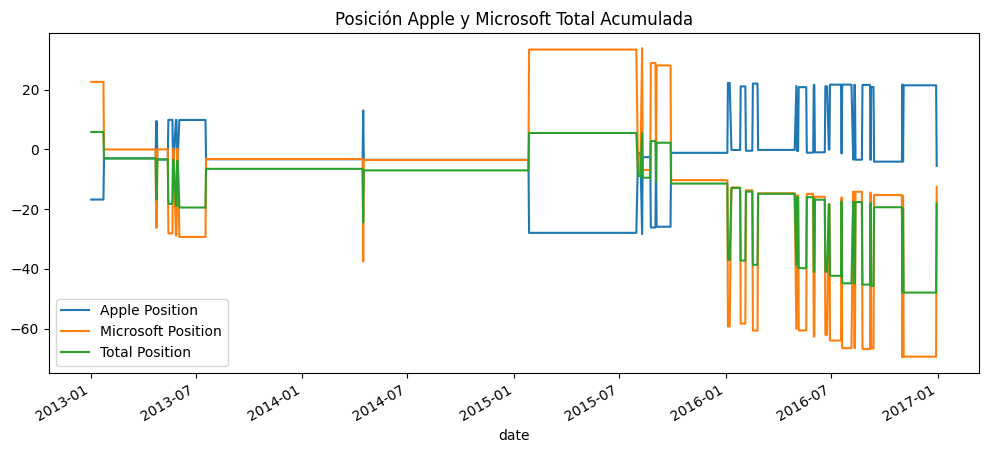

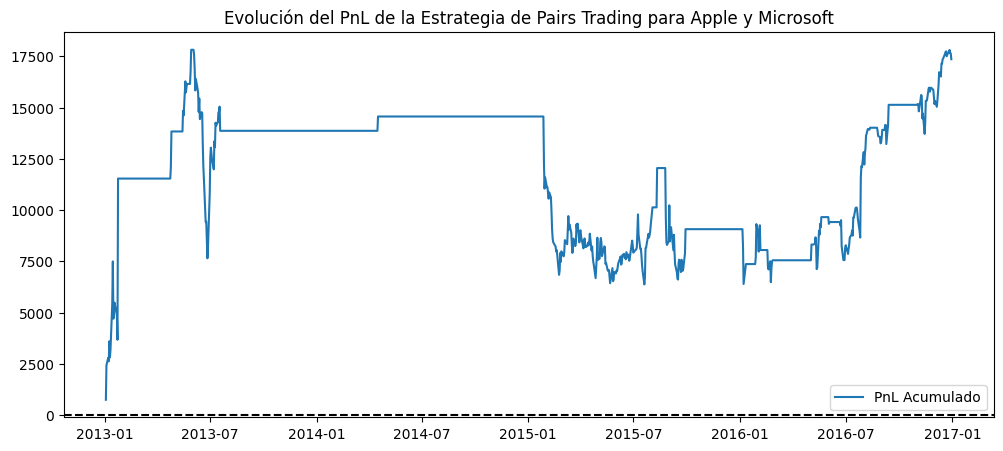

In [ ]:
# Seleccionamos el intervalo de tiempo
df_apple = df_apple.loc['2013-01-01':'2017-01-01']
df_microsoft = df_microsoft.loc['2013-01-01':'2017-01-01']

visualizar_stocks(df_apple, df_microsoft, "Apple (APPL)", "Microsoft (MSFT)", 2013, 2017)
ratio, z_score = calucular_ratio(df_apple, df_microsoft, "Apple", "Microsoft")
buy_signal, sell_signal = calcular_señales(ratio, z_score, "Apple", "Microsoft)")
calcular_señales_pairs(df_apple, df_microsoft, ratio, z_score, "Apple", "Microsoft")
pair_trading_strategy = ejecutar_trading_pairs(df_apple, df_microsoft, "Apple", "Microsoft", buy_signal, sell_signal)
calcular_posiciones(pair_trading_strategy, "Apple", "Microsoft")
calcular_pnl(df_apple, df_microsoft, ratio, z_score, buy_signal, sell_signal, "Apple", "Microsoft")

Analizando el gráfico de PNL para Apple y Microsoft, se pueden identificar tres fases, cabe destacar que estas empresas no presentan cointegración en ningún período:

Desde inicios de 2013 hasta mediados de 2013 se observa una fase de crecimiento explosivo, donde el PNL acumulado aumenta drásticamente desde 0 hasta aproximadamente 15000 puntos, con una volatilidad extrema que incluye una caída brusca seguida de una recuperación inmediata, sugiriendo un período de alta inestabilidad en la relación entre ambos activos.

De 2014 a 2015 el PNL se mantiene en un nivel estable alrededor de los 14000 puntos, seguido de una caída significativa hasta los 7000-8000 puntos, donde comienza un período de consolidación con fluctuaciones moderadas.

Finalmente, desde mediados de 2016 hasta 2017 se aprecia una nueva fase de crecimiento sostenido, recuperando niveles cercanos a los 17500 puntos.

Este comportamiento es particularmente interesante dado que las empresas no están cointegradas, lo que sugiere que las ganancias podrían estar más relacionadas con el crecimiento general del sector tecnológico que con una relación estadística entre ambos activos.

# Merck y Disney

In [ ]:
# Pareja nº4: Merck y Disney
df_merck = pd.read_csv("MRK_US_datos.csv", parse_dates=["date"], index_col="date").drop(columns=["Unnamed: 0"], errors="ignore")
df_disney = pd.read_csv("DIS_US_datos.csv", parse_dates=["date"], index_col="date").drop(columns=["Unnamed: 0"], errors="ignore")

In [ ]:
# Para seleccionar el intervalo de tiempo evaluamos la cointegración en intervalos de 3 a 5 años desde 2004 hasta 2023
cointegration_results = check_cointegration_in_periods(df_merck["adjusted_close"], df_disney["adjusted_close"], 2004, 2023, window_range=(3, 5))

# Convertimos los resultados en DataFrame para análisis
df_cointegration = pd.DataFrame(cointegration_results, columns=["Start", "End", "Window", "P-value"])
df_cointegration["Start"] = pd.to_datetime(df_cointegration["Start"])
df_cointegration.set_index("Start", inplace=True)

# Mostrar resultados con p-values significativos
print(df_cointegration[df_cointegration["P-value"] < 0.05])

                   End  Window   P-value
Start                                   
2008-01-01  2011-01-01       3  0.001369
2012-01-01  2015-01-01       3  0.014848
2019-01-01  2022-01-01       3  0.006620
2008-01-01  2012-01-01       4  0.000615
2008-01-01  2013-01-01       5  0.000173
2010-01-01  2015-01-01       5  0.027495


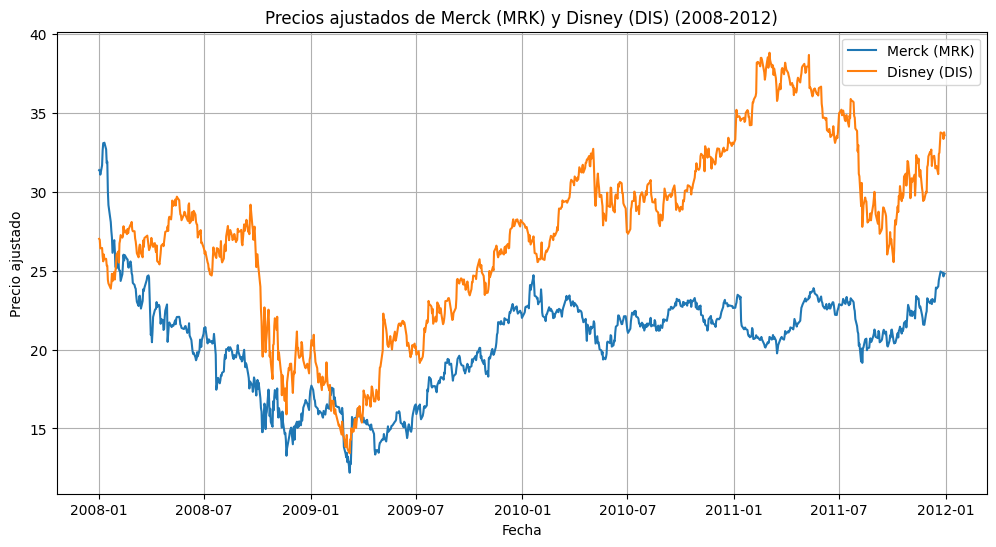

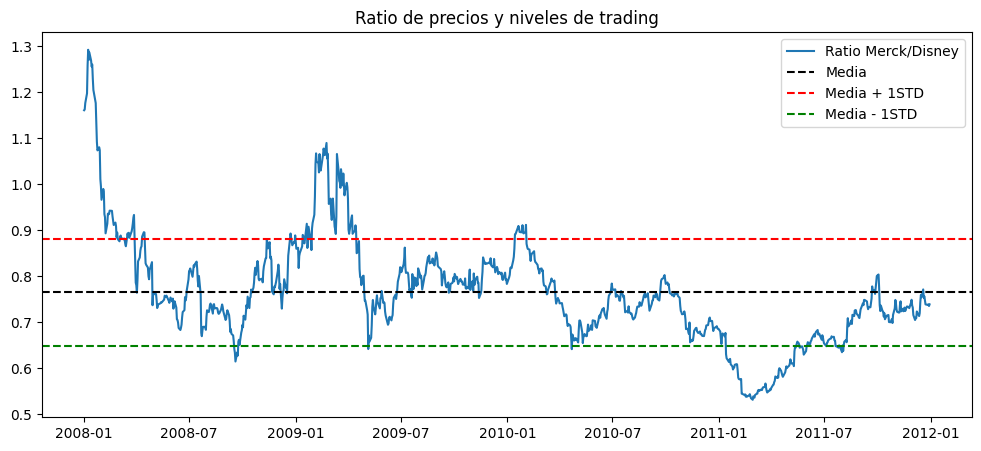

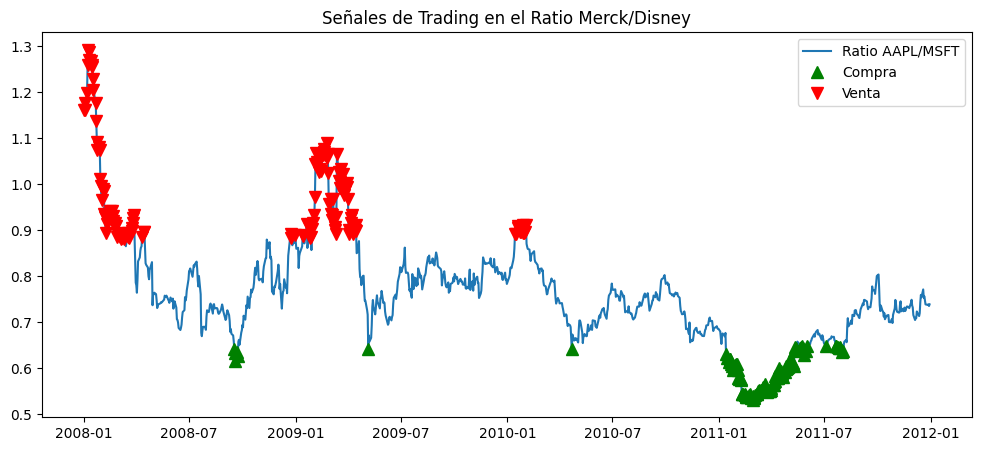

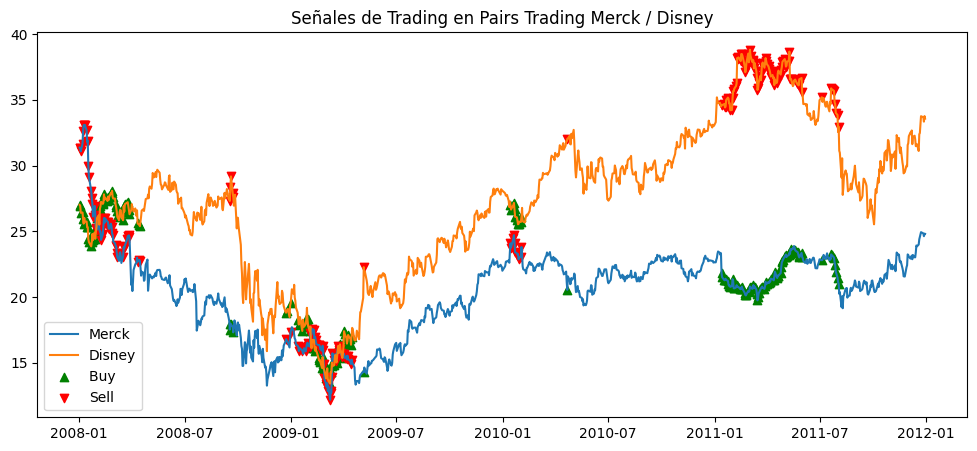

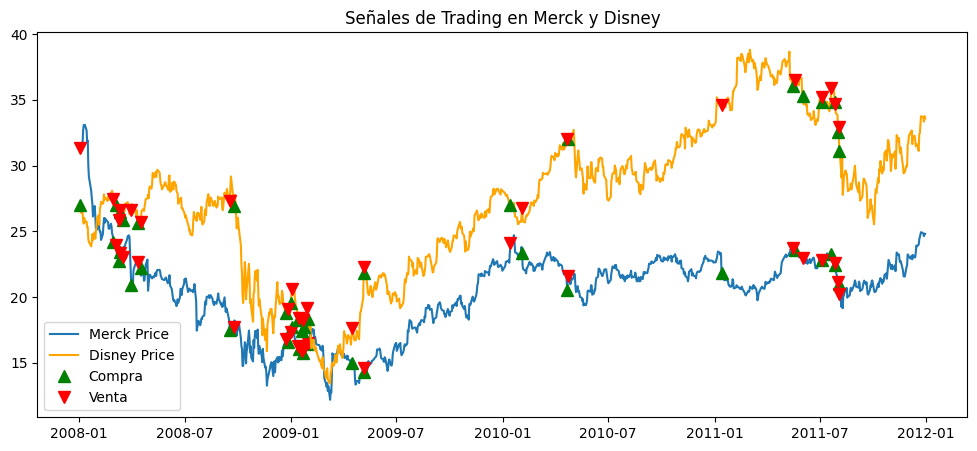

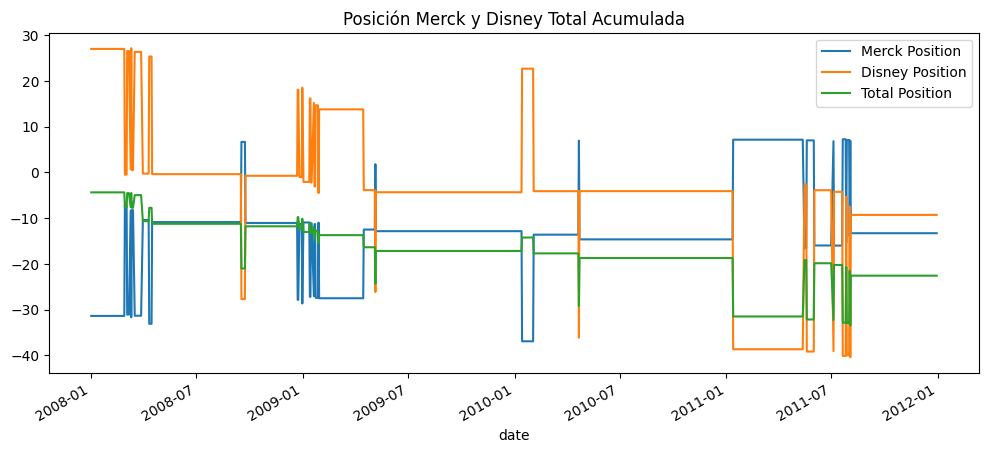

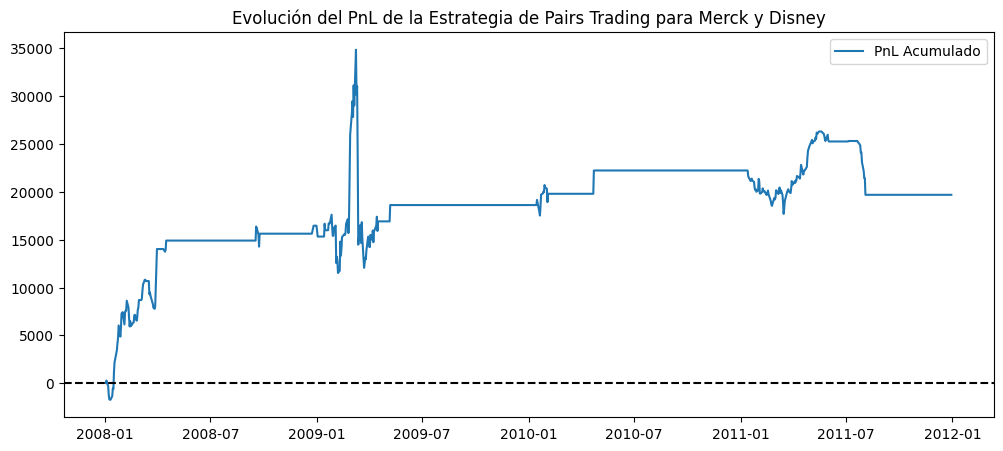

In [ ]:
# Seleccionamos el intervalo de tiempo
df_merck = df_merck.loc['2008-01-01':'2012-01-01']
df_disney = df_disney.loc['2008-01-01':'2012-01-01']

visualizar_stocks(df_merck, df_disney, "Merck (MRK)", "Disney (DIS)", 2008, 2012)
ratio, z_score = calucular_ratio(df_merck, df_disney, "Merck", "Disney")
buy_signal, sell_signal = calcular_señales(ratio, z_score, "Merck", "Disney")
calcular_señales_pairs(df_merck, df_disney, ratio, z_score, "Merck", "Disney")
pair_trading_strategy = ejecutar_trading_pairs(df_merck, df_disney, "Merck", "Disney", buy_signal, sell_signal)
calcular_posiciones(pair_trading_strategy, "Merck", "Disney")
calcular_pnl(df_merck, df_disney, ratio, z_score, buy_signal, sell_signal, "Merck", "Disney")

Analizando el gráfico de PNL para Merck y Disney, se pueden identificar tres fases, destacando algunos eventos significativos:

Hasta mediados de 2008 se observa una fase de crecimiento, donde el PNL acumulado aumenta desde 0 hasta aproximadamente 15000 puntos.

Entre finales de 2008 y principios de 2009 se aprecia una volatilidad extrema, con un gran pico  que alcanza los 35000 puntos seguido de una caída abrupta. Este comportamiento coincide con la crisis financiera global de 2008, lo que podría explicar esta volatilidad inusual en la relación entre ambos activos.

Finalmente, desde 2009 hasta 2012 el PNL se estabiliza alrededor de los 20000 puntos, con un período de fluctuación notable en 2011 que alcanza los 25000 puntos antes de volver a niveles de 20000.

# IBM e Intel

In [ ]:
# Pareja nº5: IBM e Intel
df_ibm = pd.read_csv("IBM_US_datos.csv", parse_dates=["date"], index_col="date").drop(columns=["Unnamed: 0"], errors="ignore")
df_intel = pd.read_csv("INTC_US_datos.csv", parse_dates=["date"], index_col="date").drop(columns=["Unnamed: 0"], errors="ignore")

In [ ]:
# Para seleccionar el intervalo de tiempo evaluamos la cointegración en intervalos de 3 a 5 años desde 2004 hasta 2023
cointegration_results = check_cointegration_in_periods(df_ibm["adjusted_close"], df_intel["adjusted_close"], 2004, 2023, window_range=(3, 5))

# Convertimos los resultados en DataFrame para análisis
df_cointegration = pd.DataFrame(cointegration_results, columns=["Start", "End", "Window", "P-value"])
df_cointegration["Start"] = pd.to_datetime(df_cointegration["Start"])
df_cointegration.set_index("Start", inplace=True)

# Mostrar resultados con p-values significativos
print(df_cointegration[df_cointegration["P-value"] < 0.05])

                   End  Window   P-value
Start                                   
2018-01-01  2021-01-01       3  0.007759
2017-01-01  2021-01-01       4  0.002094
2018-01-01  2022-01-01       4  0.031830
2019-01-01  2023-01-01       4  0.014334
2016-01-01  2021-01-01       5  0.003584
2017-01-01  2022-01-01       5  0.021783
2018-01-01  2023-01-01       5  0.032435


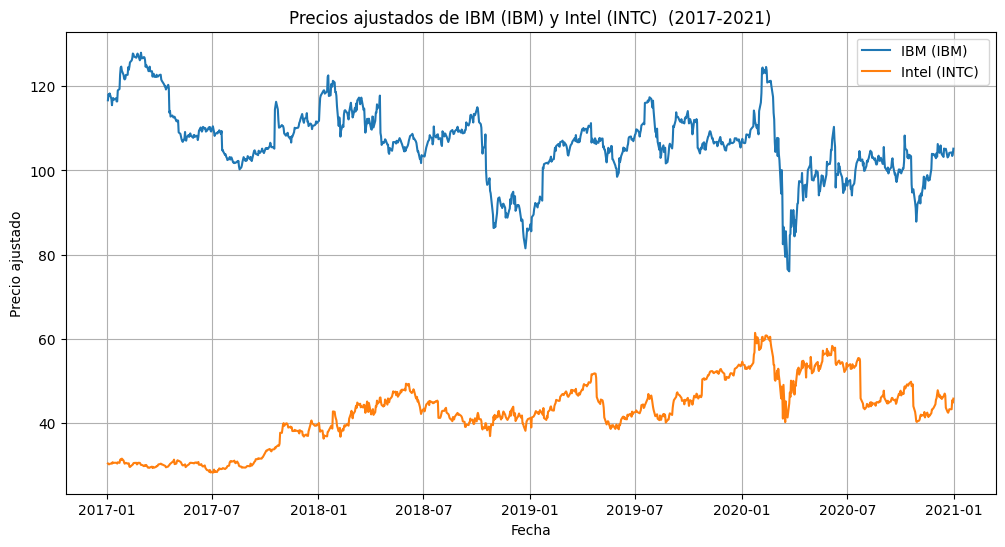

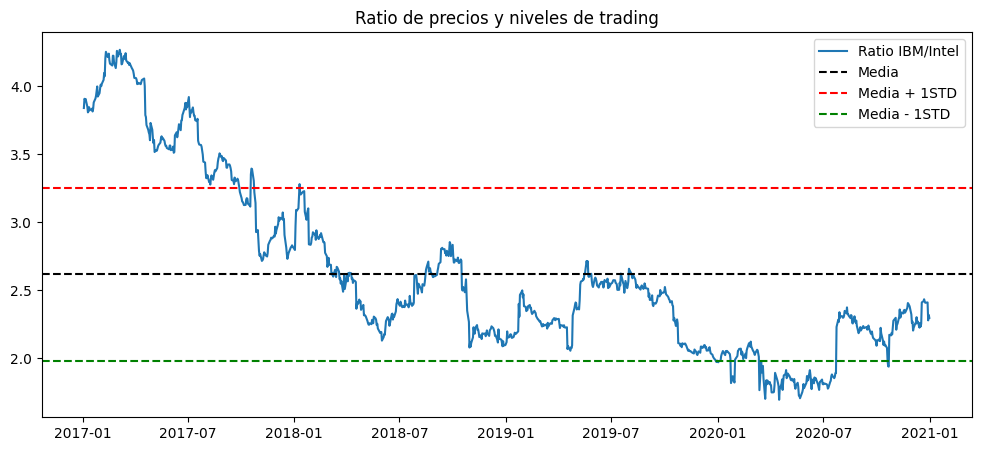

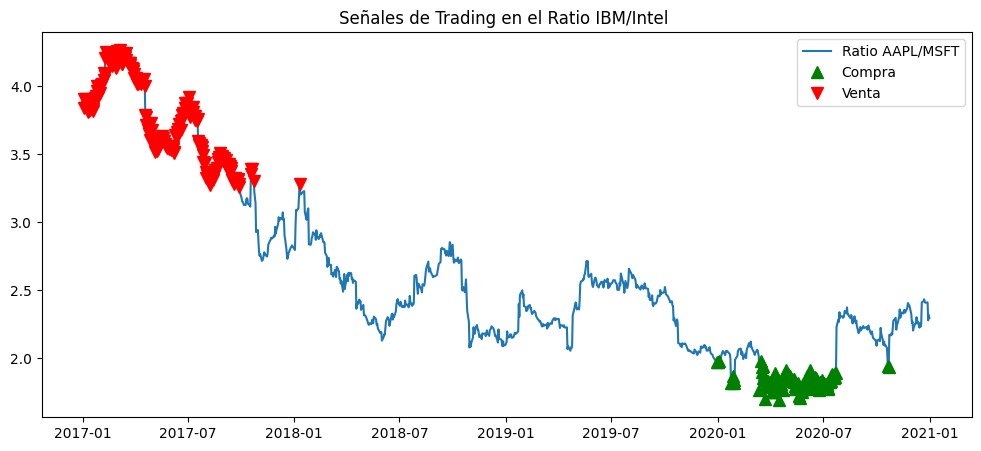

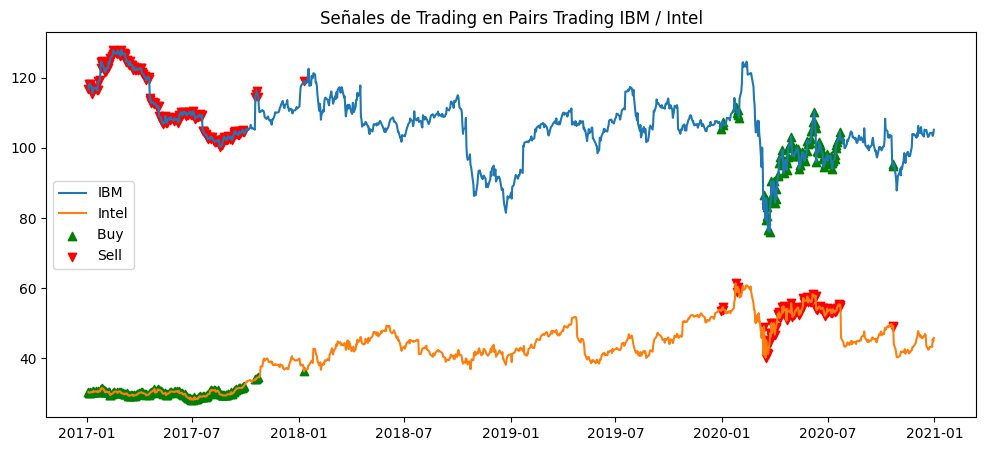

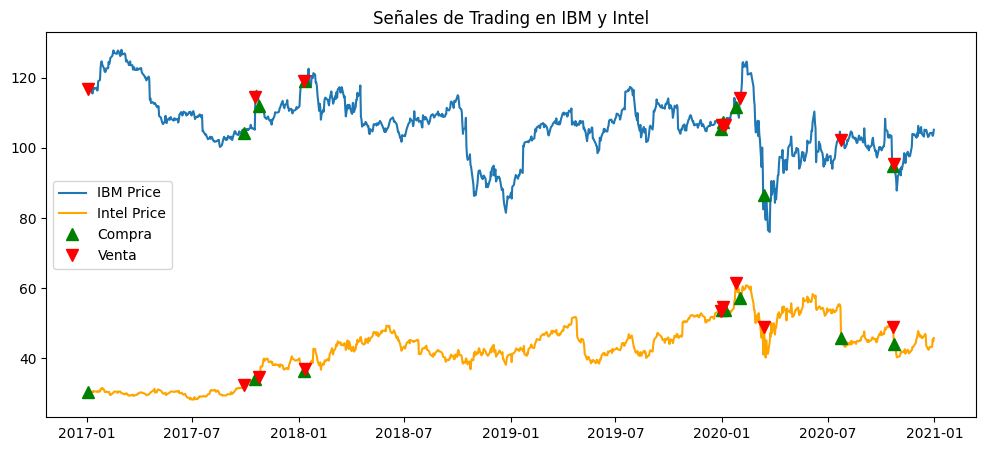

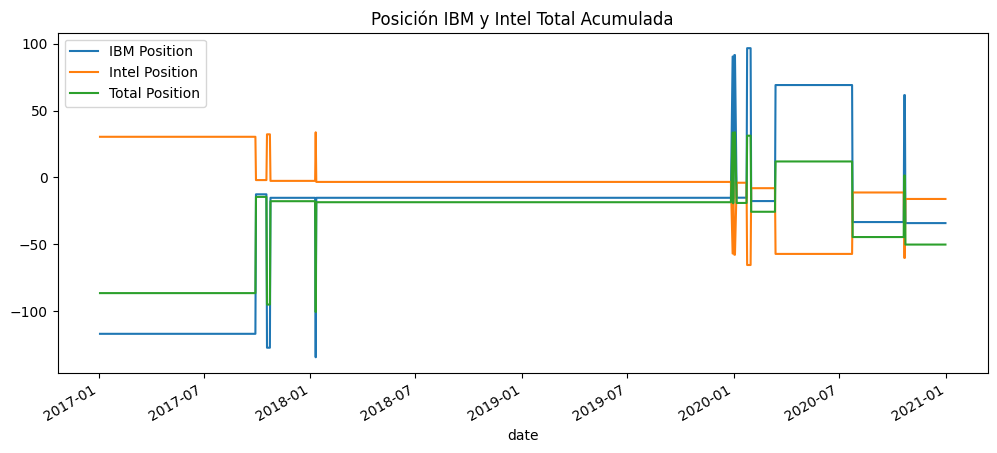

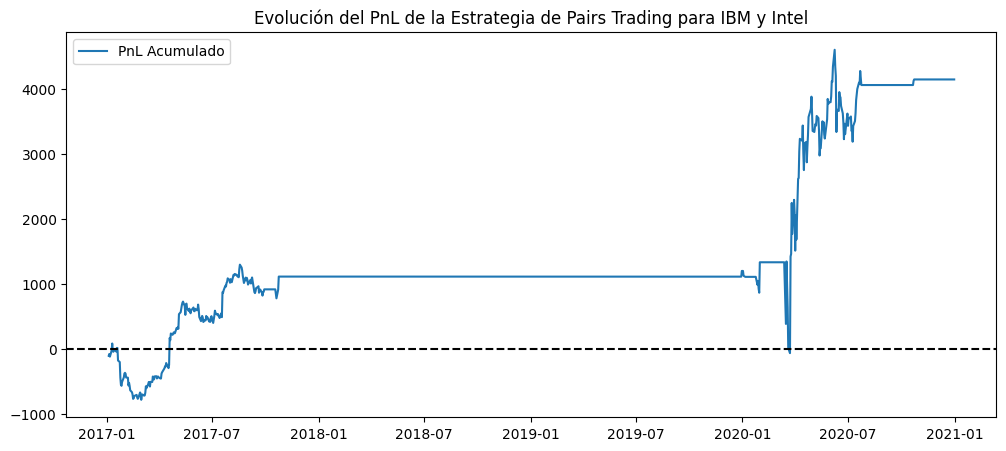

In [ ]:
# Seleccionamos el intervalo de tiempo
df_ibm = df_ibm.loc['2017-01-01':'2021-01-01']
df_intel = df_intel.loc['2017-01-01':'2021-01-01']

visualizar_stocks(df_ibm, df_intel, "IBM (IBM)", "Intel (INTC) ", 2017, 2021)
ratio, z_score = calucular_ratio(df_ibm, df_intel, "IBM", "Intel")
buy_signal, sell_signal = calcular_señales(ratio, z_score, "IBM", "Intel ")
calcular_señales_pairs(df_ibm, df_intel, ratio, z_score, "IBM", "Intel")
pair_trading_strategy = ejecutar_trading_pairs(df_ibm, df_intel, "IBM", "Intel", buy_signal, sell_signal)
calcular_posiciones(pair_trading_strategy, "IBM", "Intel")
calcular_pnl(df_ibm, df_intel, ratio, z_score, buy_signal, sell_signal, "IBM", "Intel")

Analizando el gráfico de PNL para IBM e Intel, se pueden identificar tres fases:

Desde inicios de 2017 hasta mediados de 2017 se observa una fase de volatilidad inicial, donde el PNL acumulado fluctúa entre valores negativos y positivos, llegando incluso a pérdidas, lo que sugiere un período de ajuste en la estrategia.

Desde mediados de 2017 hasta principios de 2020 el PNL se mantiene estable alrededor de los 1000 puntos, lo que indica una relación estable entre ambos activos durante este período.

Finalmente, en 2020 se observa un comportamiento dramático, con una caída abrupta hasta casi 0 seguida de un crecimiento explosivo que lleva el PNL hasta los 4000 puntos. Este movimiento extremo coincide con el inicio de la pandemia de COVID-19, que afectó significativamente al sector tecnológico.

# Conclusiones

Los diferentes pares de empresas muestran patrones de rendimiento notablemente distintos:

* Visa/Johnson & Johnson destaca como el par más estable y rentable, mostrando un crecimiento consistente hasta alcanzar los 4000 puntos sin retrocesos significativos, sugiriendo una estrategia robusta incluso durante períodos de alta volatilidad como la pandemia.

* Apple/Microsoft, a pesar de no estar cointegradas, alcanzaron niveles excepcionales de hasta 17500 puntos, aunque con alta volatilidad. Esto sugiere que sus movimientos podrían estar más influenciados por el comportamiento
general del sector tecnológico que por una relación estadística entre ambas.

* Merck/Disney exhibieron una volatilidad extrema durante la crisis de 2008, alcanzando picos de 35000 puntos, el rendimiento más alto observado entre todos los pares, aunque con una volatilidad significativa que podría indicar mayor riesgo.

* UnitedHealth/Amgen mostraron un rendimiento más moderado, alcanzando 2500 puntos antes de experimentar un declive significativo, sugiriendo una pérdida de efectividad en la estrategia a lo largo del tiempo.

* IBM/Intel presentaron el comportamiento más singular, con un largo período de estabilidad seguido de un movimiento extremo durante la pandemia, multiplicando su rendimiento hasta 4000 puntos, demostrando cómo eventos externos pueden afectar dramáticamente la relación entre pares.


En términos de estabilidad y rendimiento:
* Mayor estabilidad: Visa/Johnson & Johnson
* Mayor rendimiento pico: Merck/Disney
* Mayor volatilidad: Apple/Microsoft y Merck/Disney
* Más afectado por eventos externos: IBM/Intel (COVID-19)